![the simpsons](https://upload.wikimedia.org/wikipedia/commons/9/98/The_Simpsons_yellow_logo.svg)



#Путешествие по Спрингфилду.

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.


## Настройка окружения и подготовка данных

In [5]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook


In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [15]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


## Аугментация

In [18]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [21]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=256, sampler=train_sampler, num_workers=4)

100%|██████████| 20933/20933 [03:21<00:00, 104.12it/s]


In [23]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 369/369 [03:22<00:00,  1.82it/s]

94332 Counter({6: 2352, 4: 2318, 35: 2314, 20: 2314, 1: 2313, 37: 2311, 22: 2302, 5: 2282, 34: 2282, 13: 2280, 11: 2273, 23: 2268, 19: 2266, 31: 2265, 32: 2260, 38: 2259, 30: 2255, 21: 2255, 24: 2254, 39: 2252, 9: 2248, 7: 2247, 28: 2242, 25: 2240, 0: 2239, 2: 2238, 17: 2233, 15: 2232, 36: 2229, 41: 2227, 26: 2222, 33: 2219, 12: 2218, 27: 2211, 16: 2202, 10: 2196, 29: 2185, 3: 2179, 40: 2175, 8: 2172, 14: 2164, 18: 2139})


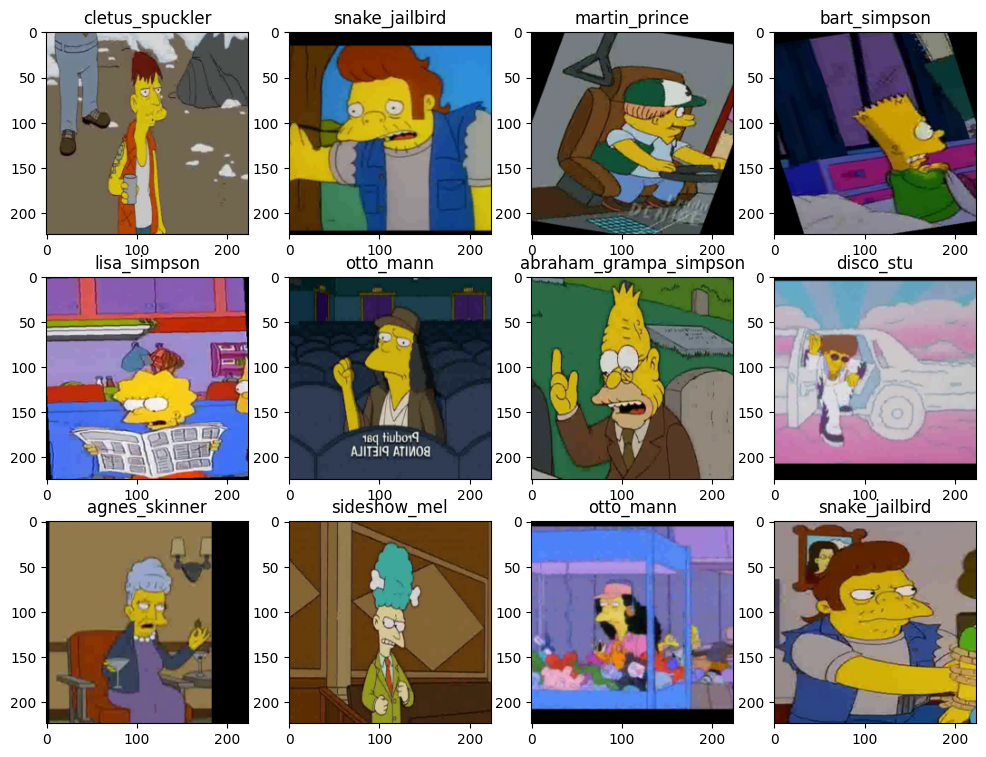

In [24]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

## Augmentation + AlexNet arch

In [25]:
def fit_epoch(model, train_dataloader, criterion, optimizer, scheduler):
    running_loss = 0
    running_corrects = 0
    running_data = 0

    for inputs, label in tqdm_notebook(train_dataloader):
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * label.size(0)
        preds = outputs.argmax(-1)
        running_corrects += (preds == label).sum()
        running_data += label.size(0)


    scheduler.step()
    train_acc = running_corrects / running_data
    train_loss = running_loss / running_data

    return train_loss, train_acc

In [26]:
def train(model,epochs,batch_size,train_dataloader):

    history = []

    log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'

    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))

    return history

In [27]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [28]:
classes = 42

model = SimpleCNN(classes)
model = model.to(DEVICE)

In [29]:
epochs=20
batch_size=256
train

history = train(model,epochs,batch_size,train_loader)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_47/3545320441.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, label in tqdm_notebook(train_dataloader):


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:   5%|▌         | 1/20 [03:48<1:12:12, 228.02s/it]

Epoch -  01, train loss:  1.9319, train acc:  0.4766


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [07:30<1:07:30, 225.00s/it]

Epoch -  02, train loss:  0.4649, train acc:  0.8662


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [11:17<1:03:55, 225.64s/it]

Epoch -  03, train loss:  0.2420, train acc:  0.9292


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  20%|██        | 4/20 [15:08<1:00:47, 227.94s/it]

Epoch -  04, train loss:  0.1610, train acc:  0.9516


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 5/20 [18:56<56:58, 227.87s/it]  

Epoch -  05, train loss:  0.1134, train acc:  0.9659


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  30%|███       | 6/20 [22:45<53:17, 228.40s/it]

Epoch -  06, train loss:  0.0581, train acc:  0.9833


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 7/20 [26:33<49:24, 228.06s/it]

Epoch -  07, train loss:  0.0402, train acc:  0.9885


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  40%|████      | 8/20 [30:20<45:34, 227.88s/it]

Epoch -  08, train loss:  0.0305, train acc:  0.9911


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  45%|████▌     | 9/20 [34:07<41:43, 227.58s/it]

Epoch -  09, train loss:  0.0264, train acc:  0.9924


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  50%|█████     | 10/20 [37:52<37:45, 226.59s/it]

Epoch -  10, train loss:  0.0227, train acc:  0.9935


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  55%|█████▌    | 11/20 [41:34<33:48, 225.44s/it]

Epoch -  11, train loss:  0.0200, train acc:  0.9946


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  60%|██████    | 12/20 [45:16<29:54, 224.37s/it]

Epoch -  12, train loss:  0.0205, train acc:  0.9944


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  65%|██████▌   | 13/20 [48:58<26:05, 223.59s/it]

Epoch -  13, train loss:  0.0198, train acc:  0.9949


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  70%|███████   | 14/20 [52:40<22:17, 222.98s/it]

Epoch -  14, train loss:  0.0174, train acc:  0.9953


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  75%|███████▌  | 15/20 [56:20<18:31, 222.31s/it]

Epoch -  15, train loss:  0.0178, train acc:  0.9951


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  80%|████████  | 16/20 [1:00:03<14:49, 222.25s/it]

Epoch -  16, train loss:  0.0180, train acc:  0.9949


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  85%|████████▌ | 17/20 [1:03:44<11:06, 222.13s/it]

Epoch -  17, train loss:  0.0178, train acc:  0.9950


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 18/20 [1:07:25<07:23, 221.59s/it]

Epoch -  18, train loss:  0.0175, train acc:  0.9952


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch:  95%|█████████▌| 19/20 [1:11:05<03:41, 221.05s/it]

Epoch -  19, train loss:  0.0177, train acc:  0.9953


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch: 100%|██████████| 20/20 [1:14:45<00:00, 224.28s/it]

Epoch -  20, train loss:  0.0177, train acc:  0.9951


## Предсказание

In [31]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)

    def __len__(self):
        return len(self.files)

In [32]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [33]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [34]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("baseline_aug_alex.csv", index=False)